# NLTP and Sentiment Analysis for Tweets about Pfizer Vaccine

I find this new dataset which is uploaded to kaggle a few days ago. The dataset contains a number of tweets related to comments on Pfizer vaccine for COVID-19. In this notebook I try to understand the typical trend and the sentiment of the tweets to see how the mass public think about the Pfizer vaccine. 

Data is obtained from: https://www.kaggle.com/gpreda/pfizer-vaccine-tweets

Written by Shing Chi Leung at 6 February 2021

In [1]:
import re

import numpy as np
import pandas as pd

from nltk import TweetTokenizer, FreqDist
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
  
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# 1. Language Analysis on Tweet about Pfizer

The whole notebook is divided into four parts: 

1. Data preparation 
 -- To fetch the data from prepared csv file

2. Data cleaning
 -- To remove hashtag, users and other punctunations which are irrelevant to the analysis

3. Word Embedding analysis
 -- To understand the distribution of words and their relation

4. Sentiment Analysis
 -- To understand the global feedback on the Pfizer Vaccine and their time dependence

In [2]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


# 1. Data Fetching and Preparation

I will need to prepare the stop words which are the common words which have no specific semantic meaning. 

In [3]:
# set up the stop words

def build_stopword_set():
    stopword_set = list(stopwords.words("english"))
    return stopword_set

stopword_set = build_stopword_set()
print("Common stopword in english: \n{}\n".format(stopword_set[:10]))

Common stopword in english: 
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]



Now I read the csv file into the pandas DataFrame and study its data structure. 

In [34]:
file_path = "gdrive/MyDrive/Colab Notebooks/vaccination_tweets.csv"
df = pd.read_csv(file_path)

print("First few rows of the database: \n{}\n".format(df.head(5)))
print("The file contains columns: {}".format(list(df.columns)))
print("The file contains {} entries.\n".format(df.shape[0]))
print("First 10 tweets are: \n{}".format(df["text"].head(10)))

First few rows of the database: 
                    id             user_name  ... favorites is_retweet
0  1340539111971516416            Rachel Roh  ...         0      False
1  1338158543359250433           Albert Fong  ...         1      False
2  1337858199140118533              eli🇱🇹🇪🇺👌  ...         0      False
3  1337855739918835717         Charles Adler  ...      2129      False
4  1337854064604966912  Citizen News Channel  ...         0      False

[5 rows x 16 columns]

The file contains columns: ['id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet']
The file contains 5205 entries.

First 10 tweets are: 
0    Same folks said daikon paste could treat a cyt...
1    While the world has been on the wrong side of ...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts are immutable, Senator, even when you'r

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                5205 non-null   int64 
 1   user_name         5205 non-null   object
 2   user_location     4120 non-null   object
 3   user_description  4874 non-null   object
 4   user_created      5205 non-null   object
 5   user_followers    5205 non-null   int64 
 6   user_friends      5205 non-null   int64 
 7   user_favourites   5205 non-null   int64 
 8   user_verified     5205 non-null   bool  
 9   date              5205 non-null   object
 10  text              5205 non-null   object
 11  hashtags          3882 non-null   object
 12  source            5204 non-null   object
 13  retweets          5205 non-null   int64 
 14  favorites         5205 non-null   int64 
 15  is_retweet        5205 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 579.6+ KB


# 2. Cleaning the text

Since the writing in tweeters is casual, I need to remove the redundant markup in the text so that the analyzer will not be distracted by the symbols which have no context meaning.

In [5]:
tweets = list(df["text"])

tweet_tokenizers = TweetTokenizer(strip_handles=True)
tweet_tokens = []

for tweet in tweets:
  tweet_tokens.append(tweet_tokenizers.tokenize(tweet.lower()))

print("The first few tweet tokens are:")
for i in range(3):
  print(tweet_tokens[i])

The first few tweet tokens are:
['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'a', 'cytokine', 'storm', '#pfizerbiontech', 'https://t.co/xehhimg1kf']
['while', 'the', 'world', 'has', 'been', 'on', 'the', 'wrong', 'side', 'of', 'history', 'this', 'year', ',', 'hopefully', ',', 'the', 'biggest', 'vaccination', 'effort', "we've", 'ev', '…', 'https://t.co/dlchrzjkhm']
['#coronavirus', '#sputnikv', '#astrazeneca', '#pfizerbiontech', '#moderna', '#covid_19', 'russian', 'vaccine', 'is', 'created', 'to', 'last', '2-4', 'years', '…', 'https://t.co/ieylckbr8p']


In [7]:
# Split the string for manual cleaning but not needed 
lemmatizer = WordNetLemmatizer()

clean_tokens = []

# clean the newlines
#df["text"] = df["text"].str.split()

for i, tweet in enumerate(tweet_tokens):

  # remove hashtag
  tweet = [re.sub(r"#[\w\s]+", "", word) for word in tweet]

  # remove user
  tweet = [re.sub(r"@[\w\s]+", "", word) for word in tweet]

  # remove webpage
  tweet = [re.sub(r"^http[\w\s:/.]+", "", word) for word in tweet]

  # remove non-letter characters
  tweet = [re.sub(r"[^\w\s]", "", word) for word in tweet]

  # remove digits
  tweet = [re.sub(r"\d+", "", word) for word in tweet]

  # remove stopwords
  #clean_text.append(" ".join([lemmatizer.lemmatize(word) for word in tweet if word not in stopword_set]))
  clean_tokens.append([lemmatizer.lemmatize(word) for word in tweet if word not in stopword_set and word != ""])

print("The first few cleaned tweets are:")
for i in range(3):
  print(clean_tokens[i])


The first few cleaned tweets are:
['folk', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm']
['world', 'wrong', 'side', 'history', 'year', 'hopefully', 'biggest', 'vaccination', 'effort', 'weve', 'ev']
['russian', 'vaccine', 'created', 'last', 'year']


In [ ]:
# manually remove hashtags and webpages but not necessary because it is done above

for i in range(len(clean_tokens)):
  for j in range(len(clean_tokens[i])-1,-1,-1):

    if clean_tokens[i][j].startswith("#") or clean_tokens[i][j].startswith("http"):
      clean_tokens[i].pop(j)

print(clean_tokens[-3:])

[['first', 'vaccine', 'dosage', 'today', 'needle', 'say', 'someone', 'always', 'reacts', 'injection', 'absolutely', 'shit'], ['even', 'covid', 'vaccine', 'post', 'twitter'], ['playing', 'withholding', 'leaving']]


# 3. Statistical Property of the Text and Word Embedding

Now I use a shallow neural network developed by Gensim to study the word distribution by the Continuous Bag of Word (CBOW). This will help me to diminish the very high dimension of individual vocabulary into a compact vector space. I will also look at the statistics of word in the tweets. 

In [8]:
all_word_tokens = []
for tweet_token in clean_tokens:
  for word in tweet_token:
    all_word_tokens.append(word)
  
freqDist = FreqDist(all_word_tokens)
most_common = freqDist.most_common()
most_common_selected = [word for word, cnt in most_common if len(word)>3 and word not in stopword_set and cnt > 100]

print("Vocab with a length >3 and appeared more than 200 times:")
for i in range(len(most_common_selected) // 10):
  print(most_common_selected[10*i:10*(i+1)-1])

Vocab with a length >3 and appeared more than 200 times:
['vaccine', 'covid', 'dose', 'first', 'pfizer', 'today', 'people', 'second', 'vaccination']
['vaccinated', 'week', 'thank', 'shot', 'getting', 'health', 'biontech', 'death', 'coronavirus']
['receive', 'effect', 'side', 'million', 'done', 'pfizerbiontech', 'know', 'thanks', 'feeling']


As expected, words like "vaccine", "health", "dose" which are closely related to the treatment of COVID-19 frequently appear in most of the tweets.

In [9]:
# vocabulary size:

print("Vocabulary size = {}".format(len(set(all_word_tokens))))

Vocabulary size = 6297


Knowing the vocaulary size will help us decide the neural network size. 

In [10]:
# word embedding

embedding_size=20

word_vecs = Word2Vec(clean_tokens, window=5, min_count=5, workers=4, size=embedding_size, iter=10)

pertained_weights = word_vecs.wv.vectors
vocab_size, embedding_size = pertained_weights.shape

print(word_vecs)
print("prince has a embedding vector: {}\n".format(word_vecs["pfizer"]))

# obtained from stack overflow for testing the word_embed 
# https://stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation

print('Result embedding shape:', pertained_weights.shape)
print('Checking similar words:')
for word in ['vaccine', 'pfizer', 'covid', 'dose']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) 
                           for similar, dist in word_vecs.wv.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))

Word2Vec(vocab=1311, size=20, alpha=0.025)
prince has a embedding vector: [-0.221505   -1.3058971  -0.91364956  0.44491306 -0.10590663  0.77824587
 -0.18307382 -0.62809575  0.5744344  -0.5630782   0.35593596  0.35001695
  1.120121   -0.23818219  0.4380598   0.64243865  0.24456775 -0.02708079
 -0.48099667  0.06323838]

Result embedding shape: (1311, 20)
Checking similar words:
  vaccine -> pfizerbiontech (0.99), pfizer (0.99), covid (0.98), authorizes (0.96), granted (0.96), moderna (0.96), approves (0.96), authorization (0.96)
  pfizer -> vaccine (0.99), pfizerbiontech (0.99), authorizes (0.97), authorization (0.97), know (0.97), granted (0.96), approves (0.96), emergency (0.96)
  covid -> receiving (0.98), receive (0.98), shot (0.98), morning (0.98), getting (0.98), administered (0.98), vaccine (0.98), nurse (0.98)
  dose -> got (0.98), first (0.98), second (0.97), today (0.97), received (0.96), feeling (0.96), st (0.96), nd (0.96)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


Again, in most text where "vaccine" and "pfizer" appear, the tweets are about "covid", "authorizes", "approves", which are directly related to when and where the vaccine can be approved for public use. The resultant Word Embedding vector will be useful if we need to feed the words into a deep neural network. 

Then we look at the distribution of the word by their principle values. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Principle Axis 2')

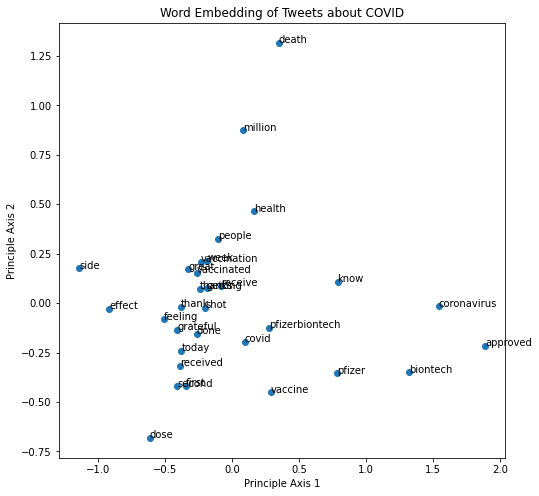

In [ ]:
X = [word_vecs[word] for word in most_common_selected]

pca = PCA(n_components=2)
analysis = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
ax.scatter(analysis[:,0], analysis[:,1])

for i, word in enumerate(most_common_selected):
  #if analysis[i,1] < 0.5:
  ax.annotate(word, xy=(analysis[i,0], analysis[i,1]))

#ax.set_ylim(-0.5,0.5)

ax.set_title("Word Embedding of Tweets about COVID")
ax.set_xlabel("Principle Axis 1")
ax.set_ylabel("Principle Axis 2")

Although the word size is small here, we can see some clustering here. For example,"pfizerbiontech", "covid", "vaccine" are much closer than other commonly found words such as "effect", "health", or "death".

# 4. Sentiment Analysis

Finally in this section I study the statistical representation of the sentiment in all the tweets. This will help us know how good/bad the mass public think about the vaccine. 

In [11]:
analyser = SentimentIntensityAnalyzer()

sent_score = []

for tweet in clean_tokens:
  tweet = " ".join(tweet)
  score = analyser.polarity_scores(tweet)
  sent_score.append(score["compound"])

sent_pred = []
for score in sent_score:
  if score > 0.05:
    sent_pred.append("Positive")
  elif score < -0.05:
    sent_pred.append("Negative")
  else:
    sent_pred.append("Neutral")

#print(clean_tokens[:5])
#print(sent_score[:5])
print("The first few tweets and their sentiment:") 
for i in range(5):
  print("{} : {}".format(clean_tokens[i], sent_pred[i]))

The first few tweets and their sentiment:
['folk', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm'] : Positive
['world', 'wrong', 'side', 'history', 'year', 'hopefully', 'biggest', 'vaccination', 'effort', 'weve', 'ev'] : Negative
['russian', 'vaccine', 'created', 'last', 'year'] : Positive
['fact', 'immutable', 'senator', 'even', 'youre', 'ethically', 'sturdy', 'enough', 'acknowledge', 'born'] : Neutral
['explain', 'need', 'vaccine'] : Neutral


We can see that sentence which describes about science discovery is characterized as neutralm while the progress in treating COVID-19 is classified as positive. 

In [35]:
# analyze the distribution of tweet

df["clean Tokens"] = clean_tokens
df["sentiment"] = sent_pred

Text(0.5, 1.0, 'Sentiment distribution')

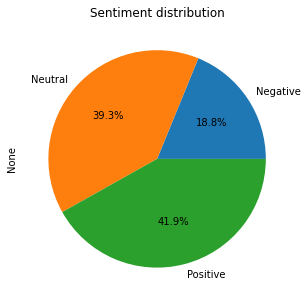

In [22]:
# some elementary analysis of the tweet distribution

df_sent_size = df.groupby("sentiment").size()

ax2 = df_sent.plot.pie(figsize=(5,5), autopct='%1.1f%%')
ax2.set_title("Sentiment distribution")

The positive tweets about the Pfizer vaccine is in general positive. 

Then we also study how influnetial the positive/negative tweets are in terms of their connection. 

In [28]:
df_sent = df.groupby("sentiment")

print("Statistics about the influence of different types of sentiment")
df_sent[['user_followers', 'user_friends', "retweets", "favorites"]].agg(["mean", "std"])

Statistics about the influence of different types of sentiment


user_followers                 ...  favorites           
                    mean            std  ...       mean        std
sentiment                                ...                      
Negative    18517.541369  125045.480280  ...   5.692543  30.875839
Neutral     51221.506595  363547.603641  ...   9.608696  68.157835
Positive    36724.966498  384172.978884  ...  12.025700  81.385547

[3 rows x 8 columns]

We can see that negative tweets has a lower number followers. They do not have a significantly different number of friends, but their retweets have a higher std, meaning that some of the negative tweets are more widespread, even though they might receive less approval by others. On the other hands, positive tweets are coming from users who are more popular. They can engage the resonance from other users suggested by their higher favourites received. But they are less retweeted compared to negative or neutral tweets.  

Finally I want to examine if there are changes in the global sentiment before and after the Pfizer vaccine is official used. 

In [66]:
# convert the stringt o datetime object
df["date"] = pd.to_datetime(df["date"])
print(type(df["date"].iloc[1]))

df_month = df.groupby(["sentiment", pd.Grouper(key='date', freq='1W')]).size() 
print(df_month)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
sentiment  date      
Negative   2020-12-13     25
           2020-12-20    136
           2020-12-27     81
           2021-01-03    115
           2021-01-10    179
           2021-01-17    175
           2021-01-24    140
           2021-01-31    101
           2021-02-07     27
Neutral    2020-12-13     72
           2020-12-20    371
           2020-12-27    284
           2021-01-03    228
           2021-01-10    306
           2021-01-17    282
           2021-01-24    221
           2021-01-31    204
           2021-02-07     79
Positive   2020-12-13     64
           2020-12-20    353
           2020-12-27    277
           2021-01-03    208
           2021-01-10    384
           2021-01-17    335
           2021-01-24    237
           2021-01-31    231
           2021-02-07     90
dtype: int64
['2020-12-13T00:00:00.000000000' '2020-12-20T00:00:00.000000000'
 '2020-12-27T00:00:00.000000000' '2021-01-03T00:00:00.000000000'
 

Text(0, 0.5, 'Count')

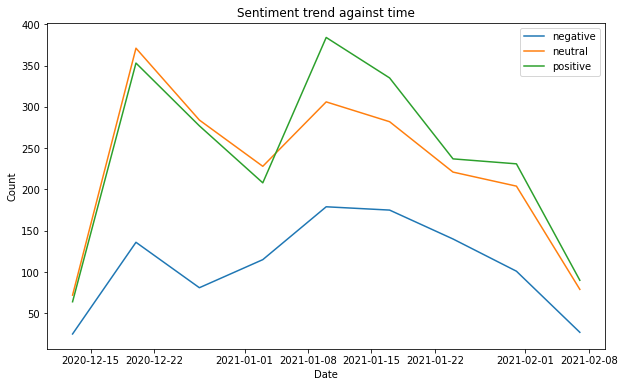

In [86]:
date_list = list(df_month.loc["Negative"].index)

fig3, ax3 = plt.subplots(figsize=(10,6), ncols=1, nrows=1)
ax3.plot(date_list, df_month.loc["Negative"], label="negative")
ax3.plot(date_list, df_month.loc["Neutral"], label="neutral")
ax3.plot(date_list, df_month.loc["Positive"], label="positive")
#ax3.plot(df_month.loc["Positive"])

ax3.legend()
ax3.set_title("Sentiment trend against time")
ax3.set_xlabel("Date")
ax3.set_ylabel("Count")


The shape of the curve follows how active the people use twitter. The simiarity of the curve shape suggests that people thinking positively or negatively about the vaccine do not significantly change their ideas. 